# Malaria Diagnosis using Neural Networks

In [88]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , InputLayer , Flatten , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

## Data Load and Processing

### Data Loading

In [89]:
data , data_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [90]:
print(data,"\n")
for d in data[0].take(3):
  print(d)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>] 

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8

In [91]:
def split_dataset(dataset , Train_Ratio , Test_Ratio, Validate_Ratio):
  Dataset_sz = len(dataset)

  train_set = dataset.take(int(Train_Ratio*Dataset_sz))

  test_dataset = dataset.skip(int(Train_Ratio*Dataset_sz))
  test_set = test_dataset.take(int(Test_Ratio*Dataset_sz))

  val_set = test_dataset.skip(int(Test_Ratio*Dataset_sz))
  return train_set,test_set,val_set

In [92]:
Train_Ratio = 0.3
Test_Ratio = 0.3
Val_Ratio = 0.4

train_set , test_set , validate_set = split_dataset(data[0],Train_Ratio,Test_Ratio,Val_Ratio)

In [93]:
print(train_set.take(1).as_numpy_iterator())

### Data Visualization

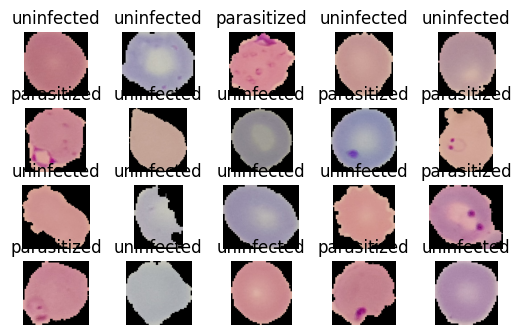

In [94]:
for it , (image,label) in enumerate(train_set.take(20)):
  ax = plt.subplot(5,5,it+1)
  plt.imshow(image)
  plt.title(data_info.features['label'].int2str(label))
  plt.axis('off')

### Data Processing

In [95]:
IMG_SIZE = 235
def normalize_pixels(image,label):
  return tf.image.resize(image,(IMG_SIZE , IMG_SIZE)) / 255.0 , label

In [96]:
train_set = train_set.map(normalize_pixels)
validate_set = validate_set.map(normalize_pixels)
test_set = test_set.map(normalize_pixels)
BATCH_SIZE = 45
train_set = train_set.shuffle(buffer_size=8,reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validate_set = validate_set.shuffle(buffer_size=8,reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Creation

In [97]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IMG_SIZE,IMG_SIZE,3)),

    Conv2D(filters = 6 , kernel_size = 5, strides = 1 , padding = 'valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2 , strides = 2),


    Conv2D(filters = 16 , kernel_size = 5 , strides = 1 , padding = 'valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2 , strides = 2),

    Flatten(),

    Dense(80 , activation = 'relu'),
    BatchNormalization(),
    Dense(12 , activation = 'relu'),
    BatchNormalization(),
    Dense(1 , activation = 'sigmoid'),
])

lenet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 232, 232, 6)       294       
                                                                 
 batch_normalization_16 (Bat  (None, 232, 232, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 116, 116, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 113, 113, 16)      1552      
                                                                 
 batch_normalization_17 (Bat  (None, 113, 113, 16)     64        
 chNormalization)                                                
                                                      

### Using Binary Cross Entropy Losses for penalizing the model for wrong predictions!

In [98]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.03),
                    loss = BinaryCrossentropy(),
                    metrics = 'accuracy',
                    )

In [99]:
history = lenet_model.fit(train_set , validation_data = validate_set , epochs = 20 , verbose = 1)

Epoch 1/3
307/307 [==============================] - 47s 139ms/step - loss: 0.4212 - accuracy: 0.7972 - val_loss: 0.8981 - val_accuracy: 0.6780
Epoch 2/3
307/307 [==============================] - 39s 126ms/step - loss: 0.2148 - accuracy: 0.9229 - val_loss: 0.7388 - val_accuracy: 0.5319
Epoch 3/3
307/307 [==============================] - 39s 127ms/step - loss: 0.1823 - accuracy: 0.9364 - val_loss: 0.8230 - val_accuracy: 0.8068


### Model Testing and Evaluation

In [100]:
test_set = test_set.batch(1)

In [101]:
test_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 235, 235, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [102]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 235, 235, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [103]:
def testing(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 18ms/step


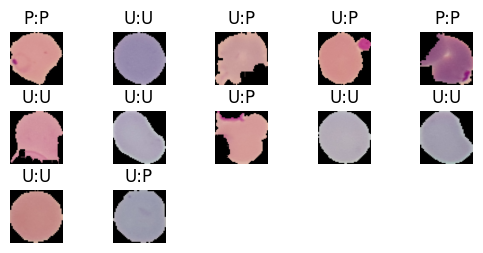

In [106]:
for i , (image , label) in enumerate(test_set.take(12)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image[0])
  plt.subplots_adjust(hspace=0.5)
  plt.title(str(testing(label.numpy()[0])) + ":" + str(testing(lenet_model.predict(image)[0][0])))

  plt.axis('off')